In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

np.random.seed(0)

In [3]:
def get_coeff(c_1, c_2, scale):
    scale_sq = scale ** 2
    part1 = (c_1 - 1) / (c_1 + c_2) + scale_sq / (1 - scale_sq)
    part2 = part1 ** 2 + (scale_sq / (1 - scale_sq)) * 4 * c_2 / (c_1 + c_2)**2
    assert(part2 >= 0)
    
    a_1_option1 = (c_1 - 1) / (c_1 + c_2) - (part1 + math.sqrt(part2)) / 2
    a_1_option2 = (c_1 - 1) / (c_1 + c_2) - (part1 - math.sqrt(part2)) / 2
    isvalid_option1 = a_1_option1 > (c_1 - 1)/(c_1 + c_2) and a_1_option1 < c_1/(c_1 + c_2)
    isvalid_option2 = a_1_option2 > (c_1 - 1)/(c_1 + c_2) and a_1_option2 < c_1/(c_1 + c_2)

    assert(isvalid_option1 or isvalid_option2)
    assert(not (isvalid_option1 and isvalid_option2))
    
    a_1 = a_1_option1 if isvalid_option1 else a_1_option2
    a_2 = 1 - 1/(c_1 + c_2) - a_1
    return (a_1, a_2)

def te(c_1, c_2, scale):
    a_1, a_2 = get_coeff(c_1, c_2, scale)
    te = 1/ ((c_1 + c_2) * a_1 / scale**2 + (c_1 + c_2) * a_2)
    return te

## Complementary covariance matrices

In [4]:
def get_coeff2(c_1, c_2, scale):
    d = (scale - 1.0/scale)**2
    coeff = [0 for i in range(4)]
    coeff[0] = -d
    coeff[1] = d * (1 + (c_1 - 1.5)/(c_1 + c_2))
    coeff[2] = 1 - 1/(c_1 + c_2) - (1 - 1/(c_1 + c_2)) * ((c_1 - 0.5) / (c_1 + c_2)) * d
    coeff[3] = - (c_1/(c_1 + c_2)) * (1 - 1/(c_1 + c_2))**2
    A = np.roots(coeff)
    a_1 = 0
    num_valid = 0
    for a in A:
        if abs(np.imag(a)) <= 0.000001 and a > (c_1 - 1)/(c_1 + c_2) and a < c_1/(c_1 + c_2):
            a_1 = a
            num_valid += 1
            
    assert(num_valid == 1)
    a_2 = 1 - 1/(c_1 + c_2) - a_1
    return (a_1, a_2)

def te2(c_1, c_2, scale):
    if scale == 1:
        return 1/ (c_1 + c_2 - 1)
    
    a_1, a_2 = get_coeff2(c_1, c_2, scale)
    scale_sq = scale**2
    te = 0.5 / ((c_1 + c_2) * (scale_sq * a_1 + a_2))
    te += 0.5 / ((c_1 + c_2) * (a_1 / scale_sq + a_2))
    return te

In [5]:
c_1 = 4.0
c_2 = 4.0
scale = 10.0

te2(c_1, c_2, scale)

0.14285714285714293

# empirical

In [6]:
# params
p = 200
c1 = 4
c2 = 4
n2 = c2 * p
sigma = 3

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

def te_target(X1, X2, beta_s, beta_t, w, sigma_2 = sigma, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def mtl_target(X1, X2, beta_s, beta_t, w, n1, n2, Sigma_1_sqrt = np.eye(p), Sigma_2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma**2 * (n1 + n2) * np.trace(K)
    model_shift_bias = n1 * (np.linalg.norm(K @ X2.T @ X2 @ beta_diff) ** 2)
    model_shift_bias += n2 * w**2 * (np.linalg.norm(K @ X1.T @ X1 @ beta_diff) ** 2)
    return (model_shift_bias + var) / (n1 + n2)

In [7]:
def opt_w_val(X1, X2, beta_s, beta_t, n1, n2, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f_val(w):
        return mtl_target(X1, X2, beta_s, beta_t, w, n1, n2)
    
    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f_val, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
    
    plt.figure(c)
    plt.plot(x_list, fun_list)
    
    return x_list[np.argmin(fun_list)]

def opt_w(X1, X2, beta_s, beta_t, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f(w):
        return te_target(X1, X2, beta_s, beta_t, w)

    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
        
    plt.figure(c)
    plt.plot(x_list, fun_list)
        
    return x_list[np.argmin(fun_list)]

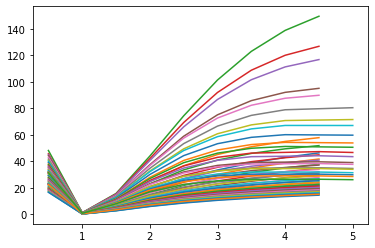

In [8]:
d = 0.00
c1_list = np.array([i for i in range(5, 26)])
scale_list = [1, 2, 4]

te_mtl_list = []

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

beta_s = beta_t + d * np.random.randn(p, 1)

for s in scale_list:
    s_diag = s * np.ones(p)
    for i in range(int(p/2), p):
        s_diag[i] = s_diag[i] / s**2

    for c1 in c1_list:
        n1 = c1 * p
        X1 = np.random.randn(n1, p) @ np.diag(s_diag)
        Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

        #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
        hat_w = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
        te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w)

        #te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
        te_mtl_list.append(te_beta_st)

        #delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
        #delta_beta = ((1 - hat_w)**2 + d**2) * delta_beta_base
        #delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
        #deviation_ub = (1 + math.sqrt(1/c1))**4
        #deviation_lb = (1 - math.sqrt(1/c1))**4

        #if delta_var / delta_beta > deviation_ub:
        #    provable_pos[0].append(c1)
        #    provable_pos[1].append(te_beta_st)
        #elif delta_var / delta_beta < deviation_lb:    
        #    provable_neg[0].append(c1)
        #    provable_neg[1].append(te_beta_st)
        #else:
        #    unknown[0].append(c1)
        #    unknown[1].append(te_beta_st)

In [9]:
te_beta_t = te_target(X1, X2, beta_s, beta_t, 0)
improvement_list = te_beta_t - np.array(te_mtl_list)

te_emp_list = [improvement_list[:21], improvement_list[21:42], improvement_list[42:63]]

print(te_emp_list)

[array([1.8851602 , 2.00821942, 2.10601893, 2.18706873, 2.24974193,
       2.30888094, 2.35962396, 2.39849017, 2.4345936 , 2.46809964,
       2.49669261, 2.52337104, 2.54442169, 2.56624392, 2.58462711,
       2.60154572, 2.61730483, 2.63232038, 2.64427148, 2.65734551,
       2.66955804]), array([1.82618669, 1.91398032, 1.98375719, 2.04588315, 2.09783427,
       2.14443397, 2.18659611, 2.22183613, 2.25466128, 2.28284285,
       2.3091492 , 2.33603197, 2.35899164, 2.38182821, 2.40049491,
       2.41773008, 2.4353826 , 2.453844  , 2.46617408, 2.48290237,
       2.4955399 ]), array([1.75734163, 1.79056778, 1.81823178, 1.84433202, 1.86739664,
       1.8895991 , 1.91076845, 1.92872692, 1.94756868, 1.96690611,
       1.98240898, 1.99912595, 2.01528474, 2.02940749, 2.04533459,
       2.05716757, 2.07137757, 2.08541651, 2.09854904, 2.109769  ,
       2.12137773])]


In [10]:
te_list = np.array([[1.0/(c_2 - 1) - te2(c_1, c_2, scale) for c_1 in c1_list] for scale in scale_list])
print(te_list)

[[0.20833333 0.22222222 0.23333333 0.24242424 0.25       0.25641026
  0.26190476 0.26666667 0.27083333 0.2745098  0.27777778 0.28070175
  0.28333333 0.28571429 0.28787879 0.28985507 0.29166667 0.29333333
  0.29487179 0.2962963  0.29761905]
 [0.20249635 0.21205677 0.21996781 0.22669342 0.23252368 0.23765244
  0.24221602 0.24631426 0.25002261 0.25339965 0.25649179 0.25933652
  0.26196455 0.26440135 0.26666833 0.26878362 0.27076274 0.27261902
  0.27436407 0.276008   0.27755966]
 [0.19490649 0.1985505  0.20171887 0.20456578 0.20717731 0.20960602
  0.21188627 0.21404185 0.21609004 0.21804385 0.21991342 0.2217069
  0.22343096 0.22509118 0.22669234 0.22823855 0.22973339 0.23118007
  0.23258141 0.23393997 0.23525805]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


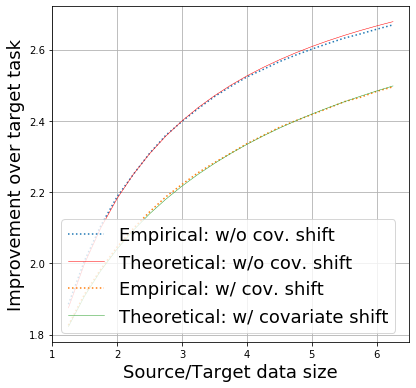

In [21]:
c_1_list = np.array([i * 1.0 for i in range(5, 26)])
scale_list = [1, 2]

te_list = sigma**2 * np.array([[1.0/(c_2 - 1) - te2(c_1, c_2, scale) for c_1 in c_1_list] for scale in scale_list])

plt.figure(figsize=(6,5.5))

for i, ts in enumerate(te_list):
    if i == 0:
        plt.plot(c_1_list / c_2,  te_emp_list[i], ls = ':', label='Empirical: w/o cov. shift')
        plt.plot(c_1_list / c_2, ts, lw=0.5, c='r', label='Theoretical: w/o cov. shift')
    if i == 1:
        plt.plot(c_1_list / c_2, te_emp_list[i], ls = ':', label='Empirical: w/ cov. shift')        
        plt.plot(c_1_list / c_2, ts, lw=0.5, label='Theoretical: w/ covariate shift')
#    if i == 2:
#        plt.plot(c_1_list / c_2, te_emp_list[i], ls = ':')
#        plt.plot(c_1_list / c_2, ts, lw=0.5, label=r'w/ covariate shift $\lambda=$' + str(scale_list[i]))

plt.xlabel('Source/Target data size', fontsize=18)
plt.ylabel('Improvement over target task', fontsize=18)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

#plt.yticks(np.arange(0.2, 0.35, 0.05), fontsize=14)
#plt.xticks(np.arange(2, 7, 1), fontsize=14)
#plt.xlim([1.15,6.3])
#plt.ylim([-1, 0.5])


plt.grid(0.4)
plt.legend(fontsize=18,loc=3)
plt.tight_layout()
plt.savefig('complementary.eps')

In [24]:
for a, b in zip(c_1_list / c_2, te_emp_list[0] / 2.8):
    print(a, b)
print()

for a, b in zip(c_1_list / c_2, te_list[0]  / 2.8):
    print(a, b)
print()

for a, b in zip(c_1_list / c_2, te_emp_list[1] / 2.8):
    print(a, b)

print()
    
for a, b in zip(c_1_list / c_2, te_list[1] / 2.8):
    print(a, b)

1.25 0.6732714998391376
1.5 0.7172212207082155
1.75 0.7521496175702846
2.0 0.7810959764101533
2.25 0.8034792615651551
2.5 0.8246003354447635
2.75 0.8427228417202154
3.0 0.8566036327426244
3.25 0.8694977136376484
3.5 0.881464156568274
3.75 0.8916759328560012
4.0 0.9012039436227084
4.25 0.9087220319948854
4.5 0.9165156851576182
4.75 0.9230811101824239
5.0 0.9291234696795786
5.25 0.9347517255662786
5.5 0.9401144225725971
5.75 0.9443826727237865
6.0 0.9490519687223343
6.25 0.9534135855444472

1.25 0.6696428571428571
1.5 0.7142857142857143
1.75 0.7499999999999999
2.0 0.7792207792207793
2.25 0.8035714285714286
2.5 0.8241758241758241
2.75 0.8418367346938774
3.0 0.8571428571428572
3.25 0.8705357142857143
3.5 0.8823529411764706
3.75 0.8928571428571429
4.0 0.9022556390977444
4.25 0.9107142857142857
4.5 0.9183673469387755
4.75 0.9253246753246753
5.0 0.9316770186335402
5.25 0.9374999999999999
5.5 0.942857142857143
5.75 0.9478021978021977
6.0 0.9523809523809524
6.25 0.9566326530612245

1.25 0.65220

In [ ]:
1.5 0.7172212207082155
2.0 0.7810959764101533
2.5 0.8246003354447635
3.0 0.8566036327426244
3.5 0.881464156568274
4.0 0.9012039436227084
4.5 0.9165156851576182
5.0 0.9291234696795786
5.5 0.9401144225725971
6.0 0.9490519687223343

1.5 0.7142857142857143
2.0 0.7792207792207793
2.5 0.8241758241758241
3.0 0.8571428571428572
3.5 0.8823529411764706
4.0 0.9022556390977444
4.5 0.9183673469387755
5.0 0.9316770186335402
5.5 0.942857142857143
6.0 0.9523809523809524

1.5 0.6835644013438512
2.0 0.7306725523777301
2.5 0.7658692751363726
3.0 0.7935129031355284
3.5 0.8153010170575891
4.0 0.8342971319716825
4.5 0.8506529312503613
5.0 0.8634750283212478
5.5 0.8763728584271449
6.0 0.886750847459198

1.5 0.6816110503613863
2.0 0.728657429270892
2.5 0.7638828339034531
3.0 0.7917244012064072
3.5 0.8144988656974353
4.0 0.8335816816265591
4.5 0.8498614784234815
5.0 0.8639473621922026
5.5 0.8762754363207138
6.0 0.887168555523363
